In [1]:
!unzip -q /content/2017_English_final.zip

In [2]:
# IMPORT LIBRARIES

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

import re
import warnings
warnings.filterwarnings('ignore')

### LOAD DATASET AND BASIC INSIGHTS

In [3]:
# List of GOLD files for training (2013–2016)
training_file_paths = [
    "2017_English_final/GOLD/Subtask_A/twitter-2013train-A.txt",
    "2017_English_final/GOLD/Subtask_A/twitter-2013dev-A.txt",
    "2017_English_final/GOLD/Subtask_A/twitter-2013test-A.txt",
    "2017_English_final/GOLD/Subtask_A/twitter-2014sarcasm-A.txt",
    "2017_English_final/GOLD/Subtask_A/twitter-2014test-A.txt",
    "2017_English_final/GOLD/Subtask_A/twitter-2015train-A.txt",
    "2017_English_final/GOLD/Subtask_A/twitter-2015test-A.txt",
    "2017_English_final/GOLD/Subtask_A/twitter-2016train-A.txt",
    "2017_English_final/GOLD/Subtask_A/twitter-2016dev-A.txt",
    "2017_English_final/GOLD/Subtask_A/twitter-2016devtest-A.txt"
]

In [4]:
# GOLD file for final test set (2016 test)
test_file_path = "2017_English_final/GOLD/Subtask_A/twitter-2016test-A.txt"

In [5]:
# data loading to read and concatenate all training files
train_dfs = []
for path in training_file_paths:
    df_temp = pd.read_csv(
        path,
        sep="\t",
        header=None,
        names=["id", "label", "tweet", "extra"],
        quoting=3,
        encoding="utf-8"
    )
    train_dfs.append(df_temp)

In [6]:
# Concatenate all training parts vertically
train_df = pd.concat(train_dfs, ignore_index=True)

In [7]:
# Load test set
test_df = pd.read_csv(
    test_file_path,
    sep="\t",
    header=None,
    names=["id", "label", "tweet", "extra"],
    quoting=3,
    encoding="utf-8")

In [8]:
# Drop the extra column
train_df = train_df[["label", "tweet"]]
test_df = test_df[["label", "tweet"]]

In [9]:
# Basic insights about training data
print("Training data - first 5 rows:")
train_df.head()

Training data - first 5 rows:


,label,tweet
0,positive,Gas by my house hit $3.39!!!! I\u2019m going t...
1,negative,Theo Walcott is still shit\u002c watch Rafa an...
2,negative,its not that I\u2019m a GSP fan\u002c i just h...
3,negative,Iranian general says Israel\u2019s Iron Dome c...
4,neutral,Tehran\u002c Mon Amour: Obama Tried to Establi...


In [77]:
print("Training data shape (rows, columns):")
print(train_df.shape)

Training data shape (rows, columns):
(29702, 4)


In [78]:
print("Training label distribution:")
print(train_df["label"].value_counts())

Training label distribution:
label
positive    12844
neutral     12249
negative     4609
Name: count, dtype: int64


In [12]:
# Basic insights about test data
print("\nTest data - first 5 rows:")
test_df.head()


Test data - first 5 rows:


,label,tweet
0,neutral,"""Picturehouse's, Pink Floyd's, 'Roger Waters: ..."
1,neutral,Order Go Set a Watchman in store or through ou...
2,negative,"""If these runway renovations at the airport pr..."
3,neutral,"""If you could ask an onstage interview questio..."
4,positive,A portion of book sales from our Harper Lee/Go...


In [13]:
print("\nTest data shape (rows, columns):")
print(test_df.shape)


Test data shape (rows, columns):
(20633, 2)


In [14]:
print("\nTest label distribution:")
print(test_df["label"].value_counts())


Test label distribution:
label
neutral     10342
positive     7059
negative     3231
Name: count, dtype: int64


### DATA PROCESSING (CLEANING, HANDLING NULLS, BASIC TRANSFORMS)

In [15]:
# Remove any rows with missing tweet or label in training and test
train_df = train_df.dropna(subset=["tweet", "label"])
test_df = test_df.dropna(subset=["tweet", "label"])

In [16]:
# Convert tweets to string
train_df["tweet"] = train_df["tweet"].astype(str)
test_df["tweet"] = test_df["tweet"].astype(str)

In [17]:
# Strip whitespace around tweets
train_df["tweet"] = train_df["tweet"].str.strip()
test_df["tweet"] = test_df["tweet"].str.strip()

In [76]:
# Create tweet length columns for EDA
train_df["tweet_length"] = train_df["tweet"].str.len()
test_df["tweet_length"] = test_df["tweet"].str.len()

print("Training data after basic cleaning, shape:")
print(train_df.shape)

Training data after basic cleaning, shape:
(29702, 4)


In [75]:
print("Test data after basic cleaning, shape:")
print(test_df.shape)

Test data after basic cleaning, shape:
(20632, 4)


### EDA

In [20]:
sns.set(style="whitegrid")

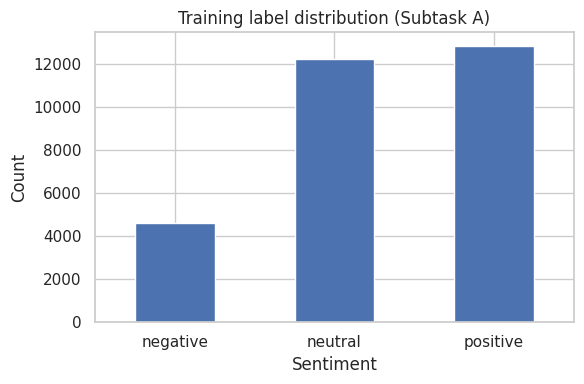

In [21]:
# Plot 1: Training label distribution
plt.figure(figsize=(6, 4))
train_df["label"].value_counts().reindex(["negative", "neutral", "positive"]).plot(kind="bar")
plt.title("Training label distribution (Subtask A)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

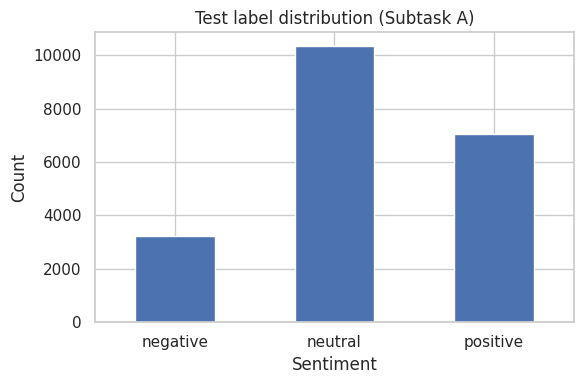

In [22]:
# Plot 2: Test label distribution
plt.figure(figsize=(6, 4))
test_df["label"].value_counts().reindex(["negative", "neutral", "positive"]).plot(kind="bar")
plt.title("Test label distribution (Subtask A)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

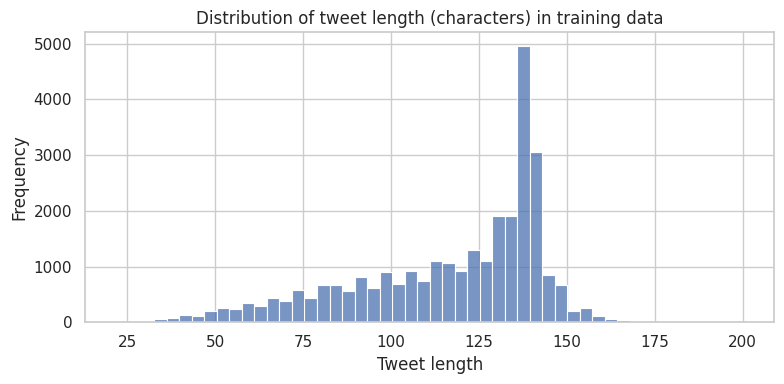

In [23]:
# Plot 3: Distribution of tweet length in training data
plt.figure(figsize=(8, 4))
sns.histplot(train_df["tweet_length"], bins=50, kde=False)
plt.title("Distribution of tweet length (characters) in training data")
plt.xlabel("Tweet length")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

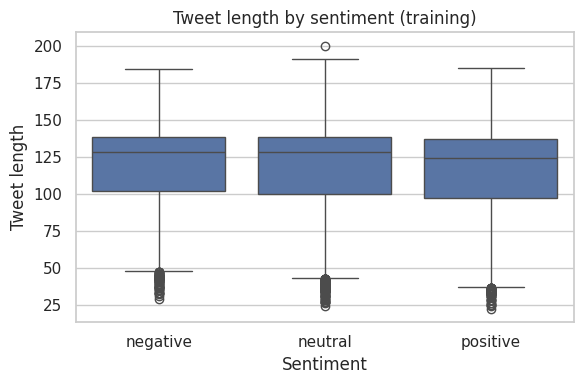

In [24]:
# Plot 4: Boxplot of tweet length by sentiment
plt.figure(figsize=(6, 4))
sns.boxplot(x=train_df["label"], y=train_df["tweet_length"], order=["negative", "neutral", "positive"])
plt.title("Tweet length by sentiment (training)")
plt.xlabel("Sentiment")
plt.ylabel("Tweet length")
plt.tight_layout()
plt.show()

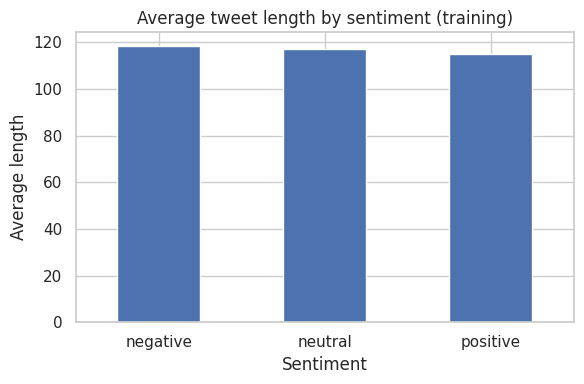

In [25]:
# Plot 5: Average tweet length by sentiment
mean_lengths = train_df.groupby("label")["tweet_length"].mean()
plt.figure(figsize=(6, 4))
mean_lengths.reindex(["negative", "neutral", "positive"]).plot(kind="bar")
plt.title("Average tweet length by sentiment (training)")
plt.xlabel("Sentiment")
plt.ylabel("Average length")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### PREPROCESSING AND FEATURE ENGINEERING (TF-IDF + N-GRAMS)

In [26]:
# text cleaning: lowercase, remove URLs, mentions, hashtags symbols, non-letter characters, extra spaces

train_clean = train_df["tweet"].str.lower()
test_clean = test_df["tweet"].str.lower()

train_clean = train_clean.str.replace(r"http\S+|www\S+|https\S+", " ", regex=True)
test_clean = test_clean.str.replace(r"http\S+|www\S+|https\S+", " ", regex=True)

train_clean = train_clean.str.replace(r"@\w+", " ", regex=True)
test_clean = test_clean.str.replace(r"@\w+", " ", regex=True)

train_clean = train_clean.str.replace("#", " ", regex=True)
test_clean = test_clean.str.replace("#", " ", regex=True)

train_clean = train_clean.str.replace(r"[^a-z\s]", " ", regex=True)
test_clean = test_clean.str.replace(r"[^a-z\s]", " ", regex=True)

train_clean = train_clean.str.replace(r"\s+", " ", regex=True)
test_clean = test_clean.str.replace(r"\s+", " ", regex=True)

train_clean = train_clean.str.strip()
test_clean = test_clean.str.strip()

train_df["clean_tweet"] = train_clean
test_df["clean_tweet"] = test_clean

print("\nOriginal vs cleaned tweets (training sample):")
train_df[["tweet", "clean_tweet"]].head()


Original vs cleaned tweets (training sample):


,tweet,clean_tweet
0,Gas by my house hit $3.39!!!! I\u2019m going t...,gas by my house hit i u m going to chapel hill...
1,Theo Walcott is still shit\u002c watch Rafa an...,theo walcott is still shit u c watch rafa and ...
2,its not that I\u2019m a GSP fan\u002c i just h...,its not that i u m a gsp fan u c i just hate n...
3,Iranian general says Israel\u2019s Iron Dome c...,iranian general says israel u s iron dome can ...
4,Tehran\u002c Mon Amour: Obama Tried to Establi...,tehran u c mon amour obama tried to establish ...


In [27]:
# Prepare features and labels for ML models
X_train_text = train_df["clean_tweet"]
X_test_text = test_df["clean_tweet"]

y_train_labels = train_df["label"]
y_test_labels = test_df["label"]

In [28]:
# TF-IDF vectoriser with unigrams and bigrams
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),     # unigrams and bigrams
    max_features=30000,     # limit vocabulary size
    min_df=5,               # ignore very rare terms
    max_df=0.95)             # ignore extremely frequent terms

In [29]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

print("\nTF-IDF feature matrix shape (train):", X_train_tfidf.shape)
print("TF-IDF feature matrix shape (test):", X_test_tfidf.shape)


TF-IDF feature matrix shape (train): (29702, 20749)
TF-IDF feature matrix shape (test): (20632, 20749)


### MACHINE LEARNING MODELS

In [30]:
# MULTINOMIAL NAIVE BAYES
nb_model = MultinomialNB()

In [31]:
# Model Training
nb_model.fit(X_train_tfidf, y_train_labels)

MultinomialNB()

In [32]:
# Predictions
nb_predictions = nb_model.predict(X_test_tfidf)

In [33]:
# Model Evaluation
nb_accuracy = accuracy_score(y_test_labels, nb_predictions)
print("\nNaive Bayes Accuracy:", nb_accuracy)


Naive Bayes Accuracy: 0.5771616905777434


In [34]:
print("\nNaive Bayes Classification Report:")
print(classification_report(y_test_labels, nb_predictions, target_names=["negative", "neutral", "positive"]))


Naive Bayes Classification Report:
              precision    recall  f1-score   support

    negative       0.66      0.08      0.15      3231
     neutral       0.65      0.61      0.62     10342
    positive       0.51      0.76      0.61      7059

    accuracy                           0.58     20632
   macro avg       0.60      0.48      0.46     20632
weighted avg       0.60      0.58      0.55     20632



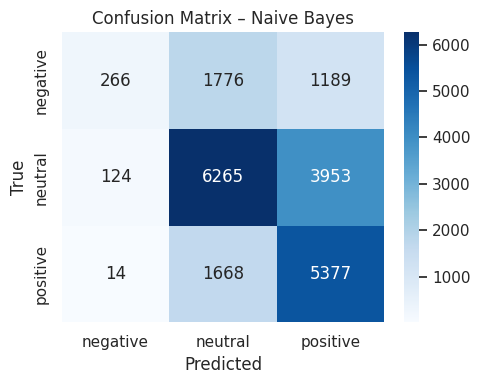

In [35]:
# Confusion Matrix
nb_cm = confusion_matrix(y_test_labels, nb_predictions, labels=["negative", "neutral", "positive"])
plt.figure(figsize=(5, 4))
sns.heatmap(nb_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["negative", "neutral", "positive"],
            yticklabels=["negative", "neutral", "positive"])
plt.title("Confusion Matrix – Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


* Logistic regression model

In [36]:
# LOGISTIC REGRESSION MODEL
log_reg_model = LogisticRegression(max_iter=1000, n_jobs=-1)

In [37]:
# Model Training
log_reg_model.fit(X_train_tfidf, y_train_labels)

LogisticRegression(max_iter=1000, n_jobs=-1)

In [38]:
# Prediction
lr_predictions = log_reg_model.predict(X_test_tfidf)

In [39]:
# Model Evaluation
lr_accuracy = accuracy_score(y_test_labels, lr_predictions)
print("\nLogistic Regression Accuracy:", lr_accuracy)


Logistic Regression Accuracy: 0.6143369523070957


In [40]:
# Classification Report
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test_labels, lr_predictions, target_names=["negative", "neutral", "positive"]))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

    negative       0.50      0.35      0.41      3231
     neutral       0.65      0.67      0.66     10342
    positive       0.60      0.66      0.63      7059

    accuracy                           0.61     20632
   macro avg       0.58      0.56      0.57     20632
weighted avg       0.61      0.61      0.61     20632



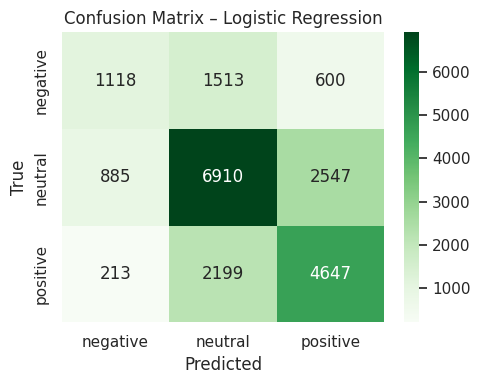

In [41]:
# Confusion Matrix
lr_cm = confusion_matrix(y_test_labels, lr_predictions, labels=["negative", "neutral", "positive"])
plt.figure(figsize=(5, 4))
sns.heatmap(lr_cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["negative", "neutral", "positive"],
            yticklabels=["negative", "neutral", "positive"])
plt.title("Confusion Matrix – Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

* LINEAR SVM MODEL

In [42]:
# LINEAR SVM MODEL
svm_model = LinearSVC()

In [43]:
# Model Training
svm_model.fit(X_train_tfidf, y_train_labels)

LinearSVC()

In [44]:
# Prediction
svm_predictions = svm_model.predict(X_test_tfidf)

In [45]:
# Model Evaluation
svm_accuracy = accuracy_score(y_test_labels, svm_predictions)
print("\nLinear SVM Accuracy:", svm_accuracy)


Linear SVM Accuracy: 0.5906843737882901


In [46]:
print("\nLinear SVM Classification Report:")
print(classification_report(y_test_labels, svm_predictions, target_names=["negative", "neutral", "positive"]))


Linear SVM Classification Report:
              precision    recall  f1-score   support

    negative       0.45      0.45      0.45      3231
     neutral       0.65      0.60      0.62     10342
    positive       0.58      0.64      0.61      7059

    accuracy                           0.59     20632
   macro avg       0.56      0.56      0.56     20632
weighted avg       0.59      0.59      0.59     20632



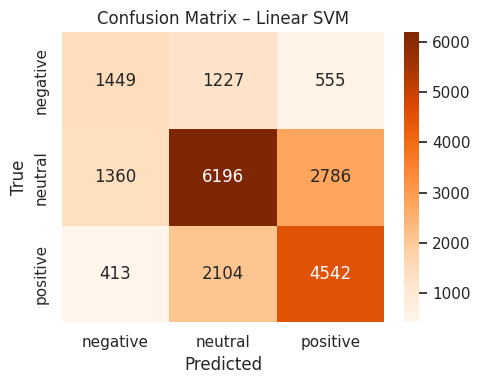

In [47]:
# Confusion Matrix
svm_cm = confusion_matrix(y_test_labels, svm_predictions, labels=["negative", "neutral", "positive"])
plt.figure(figsize=(5, 4))
sns.heatmap(svm_cm, annot=True, fmt="d", cmap="Oranges",
            xticklabels=["negative", "neutral", "positive"],
            yticklabels=["negative", "neutral", "positive"])
plt.title("Confusion Matrix – Linear SVM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

* CNN Model

In [48]:
# CNN MODEL FOR SENTIMENT CLASSIFICATION
label_mapping = {"negative": 0, "neutral": 1, "positive": 2}
y_train_cnn = train_df["label"].map(label_mapping)
y_test_cnn = test_df["label"].map(label_mapping)

y_train_cnn = y_train_cnn.astype(int).values
y_test_cnn = y_test_cnn.astype(int).values

In [50]:
# Tokenisation using the cleaned text column
cnn_train_text = train_df["clean_tweet"]
cnn_test_text = test_df["clean_tweet"]

tokenizer = Tokenizer(num_words=30000, oov_token="<OOV>")
tokenizer.fit_on_texts(cnn_train_text)

X_train_seq = tokenizer.texts_to_sequences(cnn_train_text)
X_test_seq = tokenizer.texts_to_sequences(cnn_test_text)

In [51]:
# Padding
max_length = 40
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding="post", truncating="post")
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding="post", truncating="post")

vocab_size = 30000
embedding_dim = 128

In [52]:
# Model
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation="relu"))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(64, activation="relu"))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(3, activation="softmax"))

In [53]:
# Compile Model
cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [54]:
print("\nCNN model summary:")
print(cnn_model.summary())


CNN model summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [55]:
# Train CNN
cnn_history = cnn_model.fit(
    X_train_padded,
    y_train_cnn,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    verbose=1)

Epoch 1/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 31s 69ms/step - accuracy: 0.4705 - loss: 0.9981 - val_accuracy: 0.4773 - val_loss: 0.9886
Epoch 2/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 28s 68ms/step - accuracy: 0.7045 - loss: 0.7046 - val_accuracy: 0.5146 - val_loss: 0.9588
Epoch 3/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 28s 68ms/step - accuracy: 0.8147 - loss: 0.4865 - val_accuracy: 0.5130 - val_loss: 1.0975
Epoch 4/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 42s 71ms/step - accuracy: 0.8966 - loss: 0.3029 - val_accuracy: 0.5183 - val_loss: 1.2753
Epoch 5/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 44s 78ms/step - accuracy: 0.9338 - loss: 0.1992 - val_accuracy: 0.5291 - val_loss: 1.5523
Epoch 6/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 28s 68ms/step - accuracy: 0.9570 - loss: 0.1320 - val_accuracy: 0.5301 - val_loss: 1.7554
Epoch 7/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 41s 67ms/step - accuracy: 0.9680 - loss: 0.0979 - val_accuracy: 0.5372 - val_loss: 1.9985
Epoch 8/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 29s 69ms/step - accuracy: 0.9751 - loss: 0.0800 - 

In [56]:
# Evaluate CNN on test set
cnn_test_probs = cnn_model.predict(X_test_padded)
cnn_test_preds = np.argmax(cnn_test_probs, axis=1)

cnn_accuracy = accuracy_score(y_test_cnn, cnn_test_preds)
print("\nCNN Accuracy:", cnn_accuracy)

645/645 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step

CNN Accuracy: 0.551909654905002


In [57]:
# Convert integer predictions back to label strings
inverse_label_mapping = {0: "negative", 1: "neutral", 2: "positive"}
y_test_labels_cnn = pd.Series(y_test_cnn).map(inverse_label_mapping)
y_pred_labels_cnn = pd.Series(cnn_test_preds).map(inverse_label_mapping)

In [58]:
print("\nCNN Classification Report:")
print(classification_report(y_test_labels_cnn, y_pred_labels_cnn, target_names=["negative", "neutral", "positive"]))


CNN Classification Report:
              precision    recall  f1-score   support

    negative       0.41      0.42      0.41      3231
     neutral       0.63      0.54      0.58     10342
    positive       0.53      0.63      0.58      7059

    accuracy                           0.55     20632
   macro avg       0.52      0.53      0.52     20632
weighted avg       0.56      0.55      0.55     20632



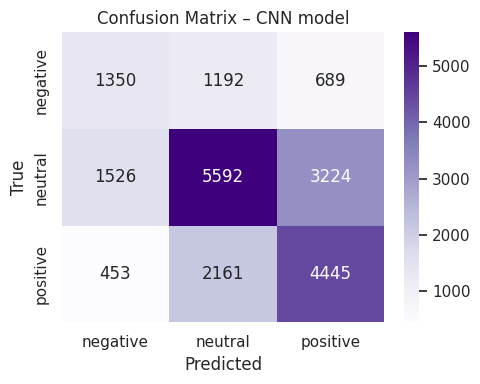

In [59]:
# Confusion Matrix
cnn_cm = confusion_matrix(y_test_labels_cnn, y_pred_labels_cnn, labels=["negative", "neutral", "positive"])
plt.figure(figsize=(5, 4))
sns.heatmap(cnn_cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=["negative", "neutral", "positive"],
            yticklabels=["negative", "neutral", "positive"])
plt.title("Confusion Matrix – CNN model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [74]:
model_accuracies = {
    "Naive Bayes": nb_accuracy,
    "Logistic Regression": lr_accuracy,
    "Linear SVM": svm_accuracy,
    "CNN": cnn_accuracy
}

accuracy_df = pd.DataFrame(model_accuracies.items(), columns=["Model", "Accuracy"])

print("Model Accuracies:")
accuracy_df

Model Accuracies:


,Model,Accuracy
0,Naive Bayes,0.577162
1,Logistic Regression,0.614337
2,Linear SVM,0.590684
3,CNN,0.551910


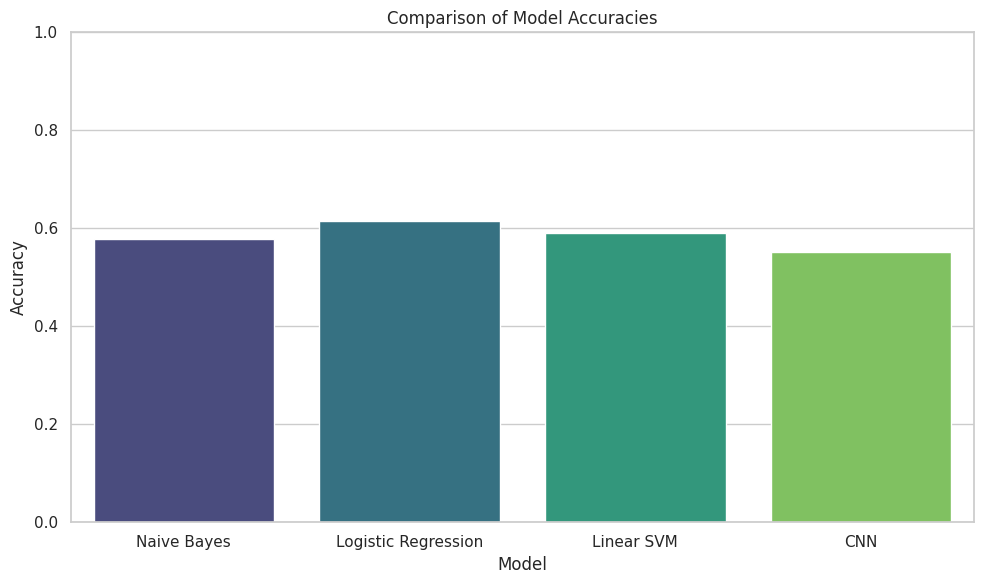

In [61]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Accuracy", data=accuracy_df, palette="viridis")
plt.title("Comparison of Model Accuracies")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [73]:
# Select 10 random rows from the test dataset
sample_df = test_df.sample(n=10, random_state=42)

# Extract text and true labels
sample_texts = sample_df["clean_tweet"]
sample_actual = sample_df["label"]

# Convert sample text to TF-IDF vectors for prediction
sample_features = tfidf_vectorizer.transform(sample_texts)

# Predict using BEST model: Logistic Regression
sample_predictions = log_reg_model.predict(sample_features)

# Create results dataframe with actual and predicted values
prediction_results = pd.DataFrame({"Tweet": sample_df["tweet"],"Actual_Label": sample_actual,"Predicted_Label": sample_predictions})

# Print results
print(" Sample Prediction Results")
prediction_results

 Sample Prediction Results


,Tweet,Actual_Label,Predicted_Label
13858,I may be mean with niall's legs sometimes but ...,neutral,negative
1710,"""@SharknadoSyfy #AprilDies because she went in...",neutral,neutral
9278,Madison Bumgarner strikes out Kris Bryant swin...,neutral,neutral
10786,"""@gatheringcopal Lol It just seems like Nicki ...",neutral,neutral
19711,@eddireader @Robbo_Iain @theSNP @TasminaSheikh...,neutral,neutral
15684,@TheZaneSimon If Rousey retired tomorrow do yo...,neutral,neutral
5377,Dustin Johnson goes -6 and in the lead - did a...,neutral,positive
7738,Sunday Supplement are honestly making out that...,positive,positive
5391,Dustin Johnson at the top of the leaderboard !...,neutral,neutral
18303,Spreading the word about our newest twilight m...,positive,neutral
